In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [29]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))

In [30]:
pdf[-10::]

,date,month,year,area,70area,minlon,minlat,maxlon,maxlat,clon,clat,tmin,tmean,t10,t90
2017-12-28_18:00:00_6,2017-12-28 18:00:00,12,2017,94,32,15.580002,-2.730003,16.419998,-1.889999,16.000000,-2.310001,-77.720001,-64.831490,-73.339996,-73.339996
2017-12-28_18:00:00_8,2017-12-28 18:00:00,12,2017,194,42,18.869995,-1.820000,19.990005,-0.559998,19.430000,-1.189999,-77.720001,-63.200508,-73.339996,-73.339996
2017-12-28_18:00:00_9,2017-12-28 18:00:00,12,2017,84,0,17.680008,-1.190002,18.520004,-0.419998,18.100006,-0.805000,-69.360001,-58.585590,-67.500000,-67.500000
2017-12-29_18:00:00_1,2017-12-29 18:00:00,12,2017,162,0,13.830002,-2.940002,15.229996,-1.959999,14.529999,-2.450001,-62.489990,-56.881413,-62.489990,-62.489990
2017-12-30_18:00:00_1,2017-12-30 18:00:00,12,2017,811,84,10.050003,-3.989998,13.690002,-1.889999,11.870003,-2.939999,-80.309998,-61.368355,-71.479996,-71.479996
2017-12-30_18:00:00_2,2017-12-30 18:00:00,12,2017,374,15,2.139999,-1.330002,4.240005,0.000000,3.190002,-0.665001,-75.659988,-59.755264,-69.529999,-69.529999
2017-12-31_18:00:00_1,2017-12-31 18:00:00,12,2017,168,7,13.690002,-3.639999,15.160004,-2.730003,14.425003,-3.185001,-71.500000,-60.368450,-67.679993,-67.679993
2017-12-31_18:00:00_2,2017-12-31 18:00:00,12,2017,291,32,13.550003,-2.659996,15.509995,-0.909996,14.529999,-1.784996,-80.329987,-61.671329,-71.500000,-71.500000
2017-12-31_18:00:00_3,2017-12-31 18:00:00,12,2017,654,69,9.699997,-2.589996,13.270004,-0.699997,11.485001,-1.644997,-88.569992,-59.590622,-71.500000,-71.500000
2017-12-31_18:00:00_4,2017-12-31 18:00:00,12,2017,118,0,16.350006,-2.519997,17.750000,-1.610001,17.050003,-2.064999,-62.509995,-58.261860,-60.899994,-60.899994


In [31]:
pdf_march = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12) &
(pdf.month == 3) & (pdf.year >=2000) & (pdf.year <=2014))
pdf_march = pdf_march.dropna()

In [11]:
pdf_oct = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12) &
(pdf.month == 10) & (pdf.year >=2000) & (pdf.year <=2014))
pdf_oct = pdf_oct.dropna()

In [32]:
era_pl = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/pressure_levels/*.nc')
era_srfc = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/surface/*.nc')

In [33]:
era_pl['ymonth'] = ('time', [str(y)+'-'+str(m)+'-'+str(h) for (y,m,h) in zip(era_pl['time.year'].values,era_pl['time.month'].values,era_pl['time.hour'].values)])
grouped='ymonth'
era_pl_mean =  era_pl.groupby(grouped).mean(dim='time')

In [34]:
era_srfc['ymonth'] = ('time', [str(y)+'-'+str(m)+'-'+str(h) for (y,m,h) in zip(era_srfc['time.year'].values,era_srfc['time.month'].values,era_srfc['time.hour'].values)])
grouped='ymonth'
era_srfc_mean =  era_srfc.groupby(grouped).mean(dim='time')

In [15]:
# era_out = get_ERA5(era_pl, era_srfc, pdf_march)
# pkl.dump(era_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march.p', 'wb'))

In [15]:
# era_clim_out = get_ERA5_clim(era_pl_mean, era_srfc_mean, pdf_oct)
# pkl.dump(era_clim_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_oct_clim.p', 'wb'))

Doing 2000-10-01 18:00:00
Doing 2000-10-01 18:00:00
Doing 2000-10-01 18:00:00
Doing 2000-10-01 18:00:00
Doing 2000-10-01 18:00:00
Doing 2000-10-01 18:00:00
Doing 2000-10-02 18:00:00
Doing 2000-10-02 18:00:00
Doing 2000-10-02 18:00:00
Doing 2000-10-02 18:00:00
Doing 2000-10-02 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-05 18:00:00
Doing 2000-10-05 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-07 18:00:00
Doing 2000-10-07 18:00:00
Doing 2000-1

Doing 2002-10-01 18:00:00
Doing 2002-10-01 18:00:00
Doing 2002-10-01 18:00:00
Doing 2002-10-02 18:00:00
Doing 2002-10-02 18:00:00
Doing 2002-10-02 18:00:00
Doing 2002-10-02 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-04 18:00:00
Doing 2002-10-05 18:00:00
Doing 2002-10-05 18:00:00
Doing 2002-10-05 18:00:00
Doing 2002-10-06 18:00:00
Doing 2002-10-07 18:00:00
Doing 2002-10-07 18:00:00
Doing 2002-10-07 18:00:00
Doing 2002-10-07 18:00:00
Doing 2002-10-08 18:00:00
Doing 2002-10-08 18:00:00
Doing 2002-10-08 18:00:00
Doing 2002-10-08 18:00:00
Doing 2002-10-08 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-10 18:00:00
Doing 2002-10-10 18:00:00
Doing 2002-1

Doing 2003-10-20 18:00:00
Doing 2003-10-20 18:00:00
Doing 2003-10-20 18:00:00
Doing 2003-10-21 18:00:00
Doing 2003-10-21 18:00:00
Doing 2003-10-21 18:00:00
Doing 2003-10-22 18:00:00
Doing 2003-10-22 18:00:00
Doing 2003-10-22 18:00:00
Doing 2003-10-22 18:00:00
Doing 2003-10-22 18:00:00
Doing 2003-10-23 18:00:00
Doing 2003-10-23 18:00:00
Doing 2003-10-23 18:00:00
Doing 2003-10-23 18:00:00
Doing 2003-10-23 18:00:00
Doing 2003-10-24 18:00:00
Doing 2003-10-24 18:00:00
Doing 2003-10-24 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-27 18:00:00
Doing 2003-10-27 18:00:00
Doing 2003-10-27 18:00:00
Doing 2003-10-27 18:00:00
Doing 2003-1

Doing 2005-10-13 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-15 18:00:00
Doing 2005-10-15 18:00:00
Doing 2005-10-15 18:00:00
Doing 2005-10-15 18:00:00
Doing 2005-10-15 18:00:00
Doing 2005-10-15 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-18 18:00:00
Doing 2005-10-18 18:00:00
Doing 2005-10-18 18:00:00
Doing 2005-10-18 18:00:00
Doing 2005-1

Doing 2007-10-07 18:00:00
Doing 2007-10-08 18:00:00
Doing 2007-10-08 18:00:00
Doing 2007-10-09 18:00:00
Doing 2007-10-09 18:00:00
Doing 2007-10-09 18:00:00
Doing 2007-10-09 18:00:00
Doing 2007-10-09 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-11 18:00:00
Doing 2007-10-11 18:00:00
Doing 2007-10-11 18:00:00
Doing 2007-10-11 18:00:00
Doing 2007-10-11 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-1

Doing 2009-10-01 18:00:00
Doing 2009-10-01 18:00:00
Doing 2009-10-02 18:00:00
Doing 2009-10-02 18:00:00
Doing 2009-10-02 18:00:00
Doing 2009-10-02 18:00:00
Doing 2009-10-02 18:00:00
Doing 2009-10-03 18:00:00
Doing 2009-10-03 18:00:00
Doing 2009-10-04 18:00:00
Doing 2009-10-04 18:00:00
Doing 2009-10-04 18:00:00
Doing 2009-10-04 18:00:00
Doing 2009-10-04 18:00:00
Doing 2009-10-05 18:00:00
Doing 2009-10-05 18:00:00
Doing 2009-10-05 18:00:00
Doing 2009-10-06 18:00:00
Doing 2009-10-06 18:00:00
Doing 2009-10-06 18:00:00
Doing 2009-10-06 18:00:00
Doing 2009-10-06 18:00:00
Doing 2009-10-07 18:00:00
Doing 2009-10-07 18:00:00
Doing 2009-10-07 18:00:00
Doing 2009-10-07 18:00:00
Doing 2009-10-08 18:00:00
Doing 2009-10-08 18:00:00
Doing 2009-10-08 18:00:00
Doing 2009-10-08 18:00:00
Doing 2009-10-08 18:00:00
Doing 2009-10-09 18:00:00
Doing 2009-10-09 18:00:00
Doing 2009-10-09 18:00:00
Doing 2009-10-09 18:00:00
Doing 2009-10-10 18:00:00
Doing 2009-10-10 18:00:00
Doing 2009-10-10 18:00:00
Doing 2009-1

Doing 2010-10-29 18:00:00
Doing 2010-10-29 18:00:00
Doing 2010-10-29 18:00:00
Doing 2010-10-30 18:00:00
Doing 2010-10-30 18:00:00
Doing 2010-10-30 18:00:00
Doing 2010-10-30 18:00:00
Doing 2010-10-30 18:00:00
Doing 2010-10-30 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2011-10-01 18:00:00
Doing 2011-10-01 18:00:00
Doing 2011-10-01 18:00:00
Doing 2011-10-01 18:00:00
Doing 2011-10-01 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-03 18:00:00
Doing 2011-10-03 18:00:00
Doing 2011-10-03 18:00:00
Doing 2011-10-03 18:00:00
Doing 2011-10-03 18:00:00
Doing 2011-10-03 18:00:00
Doing 2011-1

Doing 2012-10-21 18:00:00
Doing 2012-10-21 18:00:00
Doing 2012-10-21 18:00:00
Doing 2012-10-21 18:00:00
Doing 2012-10-21 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-23 18:00:00
Doing 2012-10-23 18:00:00
Doing 2012-10-23 18:00:00
Doing 2012-10-23 18:00:00
Doing 2012-10-23 18:00:00
Doing 2012-10-23 18:00:00
Doing 2012-10-24 18:00:00
Doing 2012-10-24 18:00:00
Doing 2012-10-24 18:00:00
Doing 2012-10-25 18:00:00
Doing 2012-10-25 18:00:00
Doing 2012-10-25 18:00:00
Doing 2012-10-25 18:00:00
Doing 2012-10-25 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-1

In [35]:
era_march = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march.p', 'rb'))
era_oct = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_oct.p', 'rb'))
era_all = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2000-2014.p', 'rb'))

In [28]:
np.array(era_all['CAPE_s']).mean()

1026.481930347199

In [25]:
era_oct['dates'][2095]

Timestamp('2011-10-31 18:00:00')

In [26]:
level = era_march.pop('level')
level = era_oct.pop('level')
level = era_all.pop('level')

In [27]:
for k in era_march.keys():
    era_march[k] = era_march[k][0:1841]

In [28]:
for k in era_oct.keys():
    era_oct[k] = era_oct[k][0:2096]

In [29]:
np.array(era_oct['CAPE']).mean()

1063.4757279858334

In [30]:
np.array(era_march['CAPE']).mean()

1237.0779014713798

In [41]:
era_march.keys()

dict_keys(['q_col', 'tmean', 'lon', 'tcwv', 'area', 'lat', 'u_col', 'u925', 'q925', 't10', 'CAPE', 'area70', 'tmin', 'r_col', 'u650', 'dates', 'v_col', 'q700'])

In [60]:
for k in era_all.keys():
    print(k)
    if k == 'dates':
        continue
    varlist = []
    for ids, ise in enumerate(era_all[k]):
        if (era_all['dates'][ids].month >=3) & (era_all['dates'][ids].month <=10):
            varlist.append(ise)
    era_all[k] = np.array(varlist)                                  

q_col
tmean
lon
tcwv
dates
area70
level
u_col
q700
q925
t10
CAPE
lat
area
u925
tmin
r_col
u650
v_col


In [59]:
era_all['dates'][0].month

1

In [61]:
def sort_vars(dic):
    q925 = np.array(dic['q925'])
    sort = np.argsort(q925)
    q = q925[sort]
    shear = (np.array(dic['u650'])-np.array(dic['u925']))[sort]
    tmin = np.array(dic['tmin'])[sort]
    linsp = np.linspace(0,len(q)-1,20)
    inds = np.round(linsp).astype(int)
    
    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q*1000)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):
    
        qmean.append(np.mean(q[start:end]))
        corr.append(stats.pearsonr(shear[start:end],tmin[start:end])[0])    
        qcorr.append(stats.pearsonr(shear[start:end],q[start:end])[0])  
    return qmean, corr, qcorr

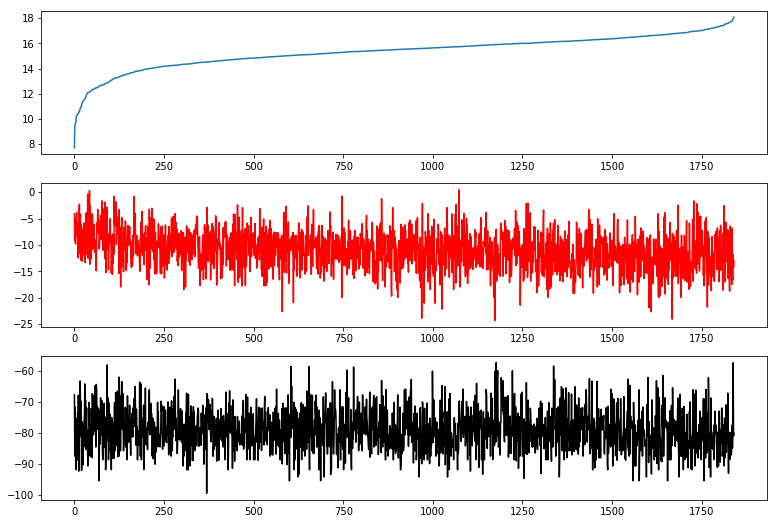

In [62]:
qmean_march, corr_march, qcorr_march = sort_vars(era_march)

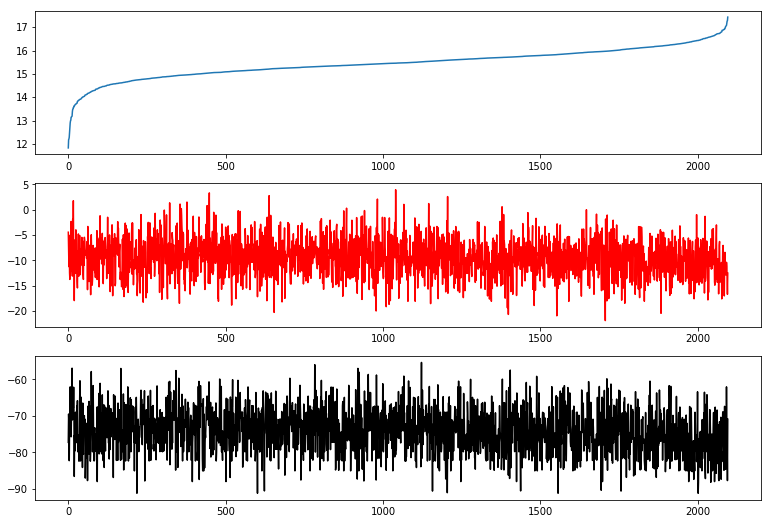

In [63]:
qmean_oct, corr_oct, qcorr_oct = sort_vars(era_oct)

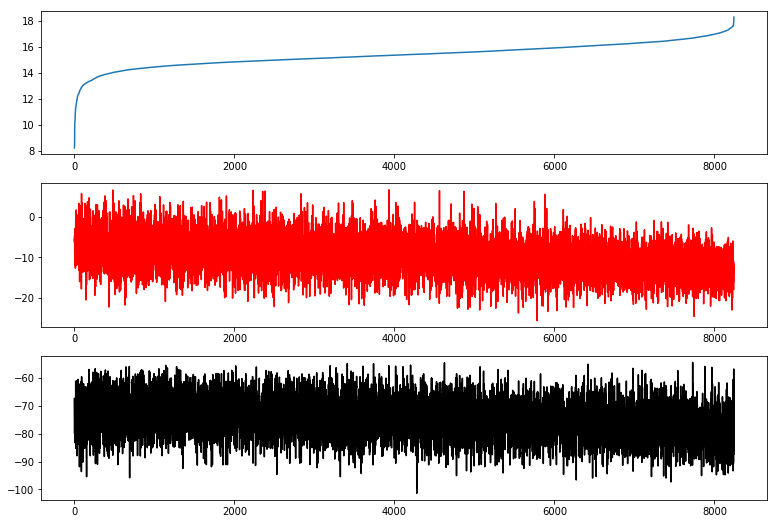

In [64]:
qmean_all, corr_all, qcorr_all = sort_vars(era_all)

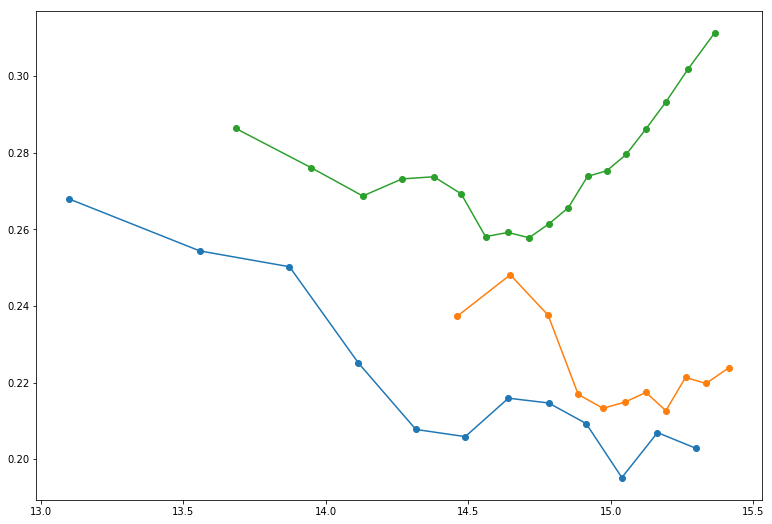

In [65]:
plt.figure(figsize=(13,9))
plt.plot(np.array(qmean_march)*1000,corr_march, '-o')
plt.plot(np.array(qmean_oct)*1000,corr_oct, '-o')
plt.plot(np.array(qmean_all)*1000,corr_all, '-o')

In [40]:
np.min(qmean_all)

0.013457925304877416

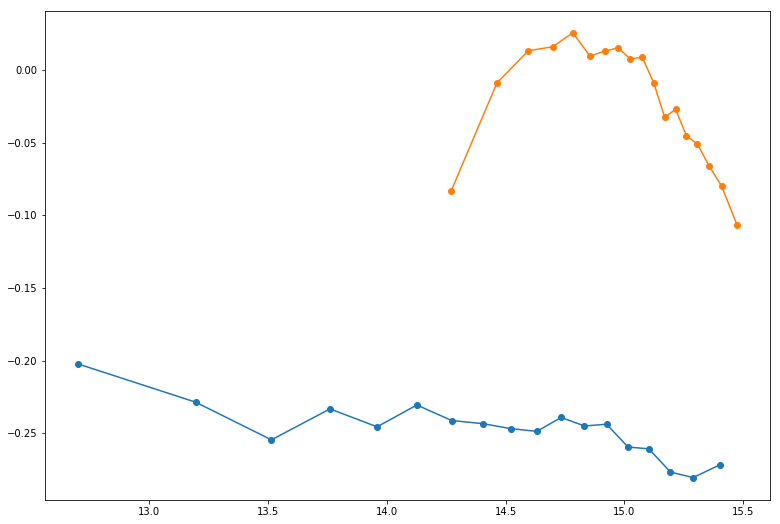

In [135]:
plt.figure(figsize=(13,9))
plt.plot(np.array(qmean_march)*1000,qcorr_march, '-o')
plt.plot(np.array(qmean_oct)*1000,qcorr_oct, '-o')